In [1]:
import glob
import random
import os
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
import pandas as pd
import librosa
import librosa.display

from torchvision.models import resnet18
import argparse
import numpy as np
import math
import itertools

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
import dycomutils

import matplotlib.pyplot as plt
from dotenv import load_dotenv
import neptune
import pandas as pd # Note: pandas is not needed for this class
import sys
sys.path.append("/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2")


In [2]:
MAIN_DIR = "/mnt/i/My Drive/TrustworthyML-assignment"

# You can just define the dictionary directly
opt = {
    "n_epochs": 4000,
    "batch_size": 64,
    "lr": 0.0002,
    "b1": 0.5,
    "b2": 0.999,
    "n_cpu": 8,
    "latent_dim": 128,
    "img_size": (1,80,16),  
    "sample_interval": 400,
    "gamma": 0.75,
    "lambda_k": 0.001,
    "lambda_gp": 10,
    "load_gen": None, #os.path.join(MAIN_DIR, "Code", "saved_models", "generator.pth"),
    "load_dis": None, #os.path.join(MAIN_DIR, "Code", "saved_models", "discriminator.pth"),
}

load_dotenv(os.path.join(MAIN_DIR, "Code", ".ENV"))

cuda = True if torch.cuda.is_available() else False

run = neptune.init_run(
    project="Botz/Audio-MI",
    name="hifigan-training",
    api_token=os.getenv("NEPTUNE_API_TOKEN")
)
run["parameters"] = opt

opt = dycomutils.config.ConfigDict(opt)


[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs-legacy.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/Botz/Audio-MI/e/AUD1-515


[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'tuple'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs-legacy.neptune.ai/help/value_of_unsupported_type
[neptune] [warning] NeptuneUnsupportedType: You're attempting to log a type that is not directly supported by Neptune (<class 'NoneType'>).
        Convert the value to a supported type, such as a string or float, or use stringify_unsupported(obj)
        for dictionaries or collections that contain unsupported values.
        For more, see https://docs-legacy.neptune.ai/help/value_of_unsupported_type


In [3]:

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Generator Code

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = (80//16, 16 // 16)
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 64 * self.init_size[0] * self.init_size[1]))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(64),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise):
        out = self.l1(noise)
        out = out.view(out.shape[0], 64, self.init_size[0], self.init_size[1])
        img = self.conv_blocks(out)
        return img.squeeze(1)
    
class ImgDiscriminator(nn.Module):
    def __init__(self, img_size=opt.img_size):
        super(ImgDiscriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_size)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.reshape(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity

In [4]:

# %%
def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.contiguous()
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, 
                      -1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)


def sinc(band,t_right):
    y_right= torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right)
    y_left= flip(y_right,0)

    y=torch.cat([y_left,Variable(torch.ones(1)).cuda(),y_right])

    return y
    

class SincConv_fast(nn.Module):
    """Sinc-based convolution
    Parameters
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 16000.
    Usage
    -----
    See `torch.nn.Conv1d`
    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=50, min_band_hz=50):

        super(SincConv_fast,self).__init__()

        if in_channels != 1:
            #msg = (f'SincConv only support one input channel '
            #       f'(here, in_channels = {in_channels:d}).')
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1
            
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = 30
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)
        hz = self.to_hz(mel)
        

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # Hamming window
        #self.window_ = torch.hamming_window(self.kernel_size)
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) # computing only half of the window
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);


        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate # Due to symmetry, I only need half of the time axes

 


    def forward(self, waveforms):
        """
        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.
        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.
        """

        self.n_ = self.n_.to(waveforms.device)

        self.window_ = self.window_.to(waveforms.device)

        low = self.min_low_hz  + torch.abs(self.low_hz_)
        
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        band=(high-low)[:,0]
        
        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). I just have expanded the sinc and simplified the terms. This way I avoid several useless computations. 
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])
        
        
        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)

        
        band_pass = band_pass / (2*band[:,None])
        

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1) 


        
        
class sinc_conv(nn.Module):

    def __init__(self, N_filt,Filt_dim,fs):
        super(sinc_conv,self).__init__()

        # Mel Initialization of the filterbanks
        low_freq_mel = 80
        high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, N_filt)  # Equally spaced in Mel scale
        f_cos = (700 * (10**(mel_points / 2595) - 1)) # Convert Mel to Hz
        b1=np.roll(f_cos,1)
        b2=np.roll(f_cos,-1)
        b1[0]=30
        b2[-1]=(fs/2)-100
                
        self.freq_scale=fs*1.0
        self.filt_b1 = nn.Parameter(torch.from_numpy(b1/self.freq_scale))
        self.filt_band = nn.Parameter(torch.from_numpy((b2-b1)/self.freq_scale))

        
        self.N_filt=N_filt
        self.Filt_dim=Filt_dim
        self.fs=fs
        

    def forward(self, x):
        
        filters=Variable(torch.zeros((self.N_filt,self.Filt_dim))).cuda()
        N=self.Filt_dim
        t_right=Variable(torch.linspace(1, (N-1)/2, steps=int((N-1)/2))/self.fs).cuda()
        
        
        min_freq=50.0;
        min_band=50.0;
        
        filt_beg_freq=torch.abs(self.filt_b1)+min_freq/self.freq_scale
        filt_end_freq=filt_beg_freq+(torch.abs(self.filt_band)+min_band/self.freq_scale)
       
        n=torch.linspace(0, N, steps=N)

        # Filter window (hamming)
        window=0.54-0.46*torch.cos(2*math.pi*n/N);
        window=Variable(window.float().cuda())

        
        for i in range(self.N_filt):
                        
            low_pass1 = 2*filt_beg_freq[i].float()*sinc(filt_beg_freq[i].float()*self.freq_scale,t_right)
            low_pass2 = 2*filt_end_freq[i].float()*sinc(filt_end_freq[i].float()*self.freq_scale,t_right)
            band_pass=(low_pass2-low_pass1)

            band_pass=band_pass/torch.max(band_pass)

            filters[i,:]=band_pass.cuda()*window

        out=F.conv1d(x, filters.view(self.N_filt,1,self.Filt_dim))
    
        return out
    

def act_fun(act_type):

 if act_type=="relu":
    return nn.ReLU()
            
 if act_type=="tanh":
    return nn.Tanh()
            
 if act_type=="sigmoid":
    return nn.Sigmoid()
           
 if act_type=="leaky_relu":
    return nn.LeakyReLU(0.2)
            
 if act_type=="elu":
    return nn.ELU()
                     
 if act_type=="softmax":
    return nn.LogSoftmax(dim=1)
        
 if act_type=="linear":
    return nn.LeakyReLU(1) # initializzed like this, but not used in forward!
            
            
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta


class MLP(nn.Module):
    def __init__(self, options):
        super(MLP, self).__init__()
        
        self.input_dim=int(options['input_dim'])
        self.fc_lay=options['fc_lay']
        self.fc_drop=options['fc_drop']
        self.fc_use_batchnorm=options['fc_use_batchnorm']
        self.fc_use_laynorm=options['fc_use_laynorm']
        self.fc_use_laynorm_inp=options['fc_use_laynorm_inp']
        self.fc_use_batchnorm_inp=options['fc_use_batchnorm_inp']
        self.fc_act=options['fc_act']
        
       
        self.wx  = nn.ModuleList([])
        self.bn  = nn.ModuleList([])
        self.ln  = nn.ModuleList([])
        self.act = nn.ModuleList([])
        self.drop = nn.ModuleList([])
       

       
        # input layer normalization
        if self.fc_use_laynorm_inp:
           self.ln0=LayerNorm(self.input_dim)
          
        # input batch normalization    
        if self.fc_use_batchnorm_inp:
           self.bn0=nn.BatchNorm1d([self.input_dim],momentum=0.05)
           
           
        self.N_fc_lay=len(self.fc_lay)
             
        current_input=self.input_dim
        
        # Initialization of hidden layers
        
        for i in range(self.N_fc_lay):
            
         # dropout
         self.drop.append(nn.Dropout(p=self.fc_drop[i]))
         
         # activation
         self.act.append(act_fun(self.fc_act[i]))
         
         
         add_bias=True
         
         # layer norm initialization
         self.ln.append(LayerNorm(self.fc_lay[i]))
         self.bn.append(nn.BatchNorm1d(self.fc_lay[i],momentum=0.05))
         
         if self.fc_use_laynorm[i] or self.fc_use_batchnorm[i]:
             add_bias=False
         
              
         # Linear operations
         self.wx.append(nn.Linear(current_input, self.fc_lay[i],bias=add_bias))
         
         # weight initialization
         self.wx[i].weight = torch.nn.Parameter(torch.Tensor(self.fc_lay[i],current_input).uniform_(-np.sqrt(0.01/(current_input+self.fc_lay[i])),np.sqrt(0.01/(current_input+self.fc_lay[i]))))
         self.wx[i].bias = torch.nn.Parameter(torch.zeros(self.fc_lay[i]))
         
         current_input=self.fc_lay[i]
         
         
    def forward(self, x):
        
      # Applying Layer/Batch Norm
      if bool(self.fc_use_laynorm_inp):
        x=self.ln0((x))
        
      if bool(self.fc_use_batchnorm_inp):
        x=self.bn0((x))
        
      for i in range(self.N_fc_lay):

        if self.fc_act[i]!='linear':
            
          if self.fc_use_laynorm[i]:
           x = self.drop[i](self.act[i](self.ln[i](self.wx[i](x))))
          
          if self.fc_use_batchnorm[i]:
           x = self.drop[i](self.act[i](self.bn[i](self.wx[i](x))))
          
          if self.fc_use_batchnorm[i]==False and self.fc_use_laynorm[i]==False:
           x = self.drop[i](self.act[i](self.wx[i](x)))
           
        else:
          if self.fc_use_laynorm[i]:
           x = self.drop[i](self.ln[i](self.wx[i](x)))
          
          if self.fc_use_batchnorm[i]:
           x = self.drop[i](self.bn[i](self.wx[i](x)))
          
          if self.fc_use_batchnorm[i]==False and self.fc_use_laynorm[i]==False:
           x = self.drop[i](self.wx[i](x)) 
          
      return x



class SincNet(nn.Module):
    
    def __init__(self,options):
       super(SincNet,self).__init__()
    
       self.cnn_N_filt=options['cnn_N_filt']
       self.cnn_len_filt=options['cnn_len_filt']
       self.cnn_max_pool_len=options['cnn_max_pool_len']
       
       
       self.cnn_act=options['cnn_act']
       self.cnn_drop=options['cnn_drop']
       
       self.cnn_use_laynorm=options['cnn_use_laynorm']
       self.cnn_use_batchnorm=options['cnn_use_batchnorm']
       self.cnn_use_laynorm_inp=options['cnn_use_laynorm_inp']
       self.cnn_use_batchnorm_inp=options['cnn_use_batchnorm_inp']
       
       self.input_dim=int(options['input_dim'])
       
       self.fs=options['fs']
       
       self.N_cnn_lay=len(options['cnn_N_filt'])
       self.conv  = nn.ModuleList([])
       self.bn  = nn.ModuleList([])
       self.ln  = nn.ModuleList([])
       self.act = nn.ModuleList([])
       self.drop = nn.ModuleList([])
       
             
       if self.cnn_use_laynorm_inp:
           self.ln0=LayerNorm(self.input_dim)
           
       if self.cnn_use_batchnorm_inp:
           self.bn0=nn.BatchNorm1d([self.input_dim],momentum=0.05)
           
       current_input=self.input_dim 
       
       for i in range(self.N_cnn_lay):
         
         N_filt=int(self.cnn_N_filt[i])
         len_filt=int(self.cnn_len_filt[i])
         
         # dropout
         self.drop.append(nn.Dropout(p=self.cnn_drop[i]))
         
         # activation
         self.act.append(act_fun(self.cnn_act[i]))
                    
         # layer norm initialization         
         self.ln.append(LayerNorm([N_filt,int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])]))

         self.bn.append(nn.BatchNorm1d(N_filt,int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i]),momentum=0.05))
            

         if i==0:
          self.conv.append(SincConv_fast(self.cnn_N_filt[0],self.cnn_len_filt[0],self.fs))
              
         else:
          self.conv.append(nn.Conv1d(self.cnn_N_filt[i-1], self.cnn_N_filt[i], self.cnn_len_filt[i]))
          
         current_input=int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])

         
       self.out_dim=current_input*N_filt



    def forward(self, x):
       batch=x.shape[0]
       seq_len=x.shape[1]
       
       if bool(self.cnn_use_laynorm_inp):
        x=self.ln0((x))
        
       if bool(self.cnn_use_batchnorm_inp):
        x=self.bn0((x))
        
       x=x.view(batch,1,seq_len)

       
       for i in range(self.N_cnn_lay):
           
         if self.cnn_use_laynorm[i]:
          if i==0:
           x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(torch.abs(self.conv[i](x)), self.cnn_max_pool_len[i]))))  
          else:
           x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i]))))   
          
         if self.cnn_use_batchnorm[i]:
          x = self.drop[i](self.act[i](self.bn[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i]))))

         if self.cnn_use_batchnorm[i]==False and self.cnn_use_laynorm[i]==False:
          x = self.drop[i](self.act[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i])))

       
       x = x.view(batch,-1)

       return x
   
def str_to_bool(s):
    if s == 'True':
         return True
    elif s == 'False':
         return False
    else:
         raise ValueError 

    
   

# %%
RESAMPLE_RATE = 16000

fs=f"{RESAMPLE_RATE}"
cw_len="1024"
cw_shift="10"   

cnn_N_filt="100,80,80"
cnn_len_filt="251,5,5"
cnn_max_pool_len="3,3,3"
cnn_use_laynorm_inp="True"
cnn_use_batchnorm_inp="False"
cnn_use_laynorm="True,True,True"
cnn_use_batchnorm="False,False,False"
cnn_act="leaky_relu,leaky_relu,leaky_relu"
cnn_drop="0.1,0.1,0.1"


fc_lay="2048,2048,2048"
fc_drop="0.1,0.1,0.1"
fc_use_laynorm_inp="True"
fc_use_batchnorm_inp="False"
fc_use_batchnorm="True,True,True"
fc_use_laynorm="False,False,False"
fc_act="leaky_relu,leaky_relu,leaky_relu"

class_lay="1"
class_drop="0.0"
class_use_laynorm_inp="False"
class_use_batchnorm_inp="False"
class_use_batchnorm="False"
class_use_laynorm="False"
class_act="softmax"

lr="0.0004"
batch_size="128"
N_epochs="1500"
N_batches="800"
N_eval_epoch="8"
seed="1234"

# %%
cnn_N_filt=list(map(int, cnn_N_filt.split(',')))
cnn_len_filt=list(map(int, cnn_len_filt.split(',')))
cnn_max_pool_len=list(map(int, cnn_max_pool_len.split(',')))
cnn_use_laynorm_inp=str_to_bool(cnn_use_laynorm_inp)
cnn_use_batchnorm_inp=str_to_bool(cnn_use_batchnorm_inp)
cnn_use_laynorm=list(map(str_to_bool, cnn_use_laynorm.split(',')))
cnn_use_batchnorm=list(map(str_to_bool, cnn_use_batchnorm.split(',')))
cnn_act=list(map(str, cnn_act.split(',')))
cnn_drop=list(map(float, cnn_drop.split(',')))


#[dnn]
fc_lay=list(map(int, fc_lay.split(',')))
fc_drop=list(map(float, fc_drop.split(',')))
fc_use_laynorm_inp=str_to_bool(fc_use_laynorm_inp)
fc_use_batchnorm_inp=str_to_bool(fc_use_batchnorm_inp)
fc_use_batchnorm=list(map(str_to_bool, fc_use_batchnorm.split(',')))
fc_use_laynorm=list(map(str_to_bool, fc_use_laynorm.split(',')))
fc_act=list(map(str, fc_act.split(',')))

#[class]
class_lay=list(map(int, class_lay.split(',')))
class_drop=list(map(float, class_drop.split(',')))
class_use_laynorm_inp=str_to_bool(class_use_laynorm_inp)
class_use_batchnorm_inp=str_to_bool(class_use_batchnorm_inp)
class_use_batchnorm=list(map(str_to_bool, class_use_batchnorm.split(',')))
class_use_laynorm=list(map(str_to_bool, class_use_laynorm.split(',')))
class_act=list(map(str, class_act.split(',')))


In [5]:
wlen=4000


# %%
# Feature extractor CNN
CNN_arch = {
    'input_dim': wlen,
    'fs': int(fs),
    'cnn_N_filt': cnn_N_filt,
    'cnn_len_filt': cnn_len_filt,
    'cnn_max_pool_len':cnn_max_pool_len,
    'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
    'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
    'cnn_use_laynorm':cnn_use_laynorm,
    'cnn_use_batchnorm':cnn_use_batchnorm,
    'cnn_act': cnn_act,
    'cnn_drop':cnn_drop,          
}


CNN_net=SincNet(CNN_arch)
CNN_net.cuda()



DNN1_arch = {
    'input_dim': CNN_net.out_dim,
    'fc_lay': fc_lay,
    'fc_drop': fc_drop, 
    'fc_use_batchnorm': fc_use_batchnorm,
    'fc_use_laynorm': fc_use_laynorm,
    'fc_use_laynorm_inp': fc_use_laynorm_inp,
    'fc_use_batchnorm_inp':fc_use_batchnorm_inp,
    'fc_act': fc_act,
}

DNN1_net=MLP(DNN1_arch)
DNN1_net.cuda()


DNN2_arch = {'input_dim':fc_lay[-1] ,
          'fc_lay': class_lay,
          'fc_drop': class_drop, 
          'fc_use_batchnorm': class_use_batchnorm,
          'fc_use_laynorm': class_use_laynorm,
          'fc_use_laynorm_inp': class_use_laynorm_inp,
          'fc_use_batchnorm_inp':class_use_batchnorm_inp,
          'fc_act': class_act,
          }


DNN2_net=MLP(DNN2_arch)
DNN2_net.cuda()

# %%
inp = torch.randn(2,  wlen).cuda()
out1 = CNN_net(inp)
print(out1.shape)

print(CNN_net.out_dim)
out2 = DNN1_net(out1)
print(out2.shape)

# %%
pout=DNN2_net(DNN1_net(CNN_net(inp)))
print(pout.shape)

/home/desild/work/academic/sem3/TrustworthyML-assignment/.conda/lib/python3.11/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  warnings.warn(


torch.Size([2, 10960])
10960
torch.Size([2, 2048])
torch.Size([2, 1])


In [6]:
CNN_net_sr=SincNet(CNN_arch)
CNN_net_sr.cuda()
DNN1_net_sr=MLP(DNN1_arch)
DNN1_net_sr.cuda()

DNN2_arch_sr = {'input_dim':fc_lay[-1] ,
          'fc_lay': [35],
          'fc_drop': class_drop, 
          'fc_use_batchnorm': class_use_batchnorm,
          'fc_use_laynorm': class_use_laynorm,
          'fc_use_laynorm_inp': class_use_laynorm_inp,
          'fc_use_batchnorm_inp':class_use_batchnorm_inp,
          'fc_act': class_act,
          }


DNN2_net_sr=MLP(DNN2_arch_sr)
DNN2_net_sr.cuda()

sr_weight = torch.load("/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/models/SINCNET_SR/20251129_142613/checkpoint.pth", weights_only=False)
CNN_net_sr.load_state_dict(sr_weight['CNN_net'])
DNN1_net_sr.load_state_dict(sr_weight['DNN1_net'])
DNN2_net_sr.load_state_dict(sr_weight['DNN2_net'])

<All keys matched successfully>

In [7]:
from common_local.utils import load_wav_to_torch, load_filepaths_and_text, to_gpu
from common_local.audio_processing import dynamic_range_compression, dynamic_range_decompression
from sentence_transformers import SentenceTransformer
import librosa
import random
from typing import Optional, List, Tuple

load_in_memory = {}

class MelAudioLoaderVoxCeleb(torch.utils.data.Dataset):
    """
        1) loads audio,text pairs
        2) computes mel-spectrograms from audio files.
    """

    def __init__(self, main_file, filter_length, hop_length, win_length,
                 n_mel_channels, sampling_rate, mel_fmin, mel_fmax, segment_length, max_wav_value, base_directory='..',
                 filter_speakers: Optional[List[str]] = None):
        
        self.main_file = main_file
        if filter_speakers is not None:
            self.main_file = self.main_file[self.main_file['speaker_id'].isin(filter_speakers)]
            print(f"Filtered dataset to {len(self.main_file)} items for speakers: {filter_speakers}")

        self.max_wav_value = max_wav_value
        self.sampling_rate = sampling_rate
        self.base_directory = base_directory
        self.random_amp = 0.2
        
        self.filter_length = filter_length
        self.hop_length = hop_length
        self.win_length = win_length
        self.n_mel_channels = n_mel_channels
        self.mel_fmin = mel_fmin
        self.mel_fmax = mel_fmax
        self.stats = {
            "audio_len_distribution": {},
        }

        
        self.speaker_id2id_map = {}
        self.segment_length = segment_length
        random.seed(1234)
        self.main_file = self.main_file.sample(frac=1).reset_index(drop=True)
        

    def spectral_normalize(self, magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output
    
    def load_text(self, file_path):
        file_path = file_path.replace("WAV.wav", "WRD")
        with open(file_path, 'r') as f:
            text = f.read().strip()
            
        text = text.split('\n')
        text = [x.strip().split(' ', 2) for x in text if len(x.split(' ', 2)) == 3]
        return [int(x[0]) for x in text], [int(x[1]) for x in text], [x[2] for x in text]
    
    def get_mel_audio_pair(self, filename):
        if filename not in load_in_memory:
            audio, sampling_rate = librosa.load(filename, sr=None)
            load_in_memory[filename] = {}
            load_in_memory[filename]["audio"] = (audio, sampling_rate)
        else:
            audio, sampling_rate = load_in_memory[filename]["audio"]

        # if sampling_rate != self.sampling_rate:
        #     raise ValueError("{} {} SR doesn't match target {} SR".format(
        #         sampling_rate, self.sampling_rate))
        
        #
        # if RESAMPLE_RATE != self.sampling_rate:
        #import soundfile as sf
        #sf.write("before_resample.wav", audio, sampling_rate)
        audio = librosa.resample(audio, orig_sr=sampling_rate, target_sr=config.sampling_rate)
        #sf.write("after_resample.wav", audio, sampling_rate//8)
        audio = torch.from_numpy(audio)

        self.stats["audio_len_distribution"][filename] = audio.size(0)
        # Take segment
        if audio.size(0) >= self.segment_length:
            max_audio_start = audio.size(0) - self.segment_length
            audio_start = random.randint(0, max_audio_start)
            audio = audio[audio_start:audio_start+self.segment_length]
        else:
            audio = torch.nn.functional.pad(
                audio, (0, self.segment_length - audio.size(0)), 'constant').data
        
        #sf.write("after_resample2.wav", audio.numpy(), sampling_rate//8)
        audio = audio * random.uniform(1.0 - self.random_amp, 1.0 + self.random_amp)
        audio_norm = audio / self.max_wav_value
        mel_spec = librosa.feature.melspectrogram(
            y=audio.numpy(),
            sr=self.sampling_rate,
            n_fft=self.filter_length,
            hop_length=self.hop_length,
            win_length=self.win_length,
            n_mels=self.n_mel_channels,
            fmin=self.mel_fmin,
            fmax=self.mel_fmax
        )
        
        mel_spec = torch.from_numpy(mel_spec).unsqueeze(0)
        mel_output = self.spectral_normalize(mel_spec)
        mel_output = mel_output.squeeze(0)
        return mel_output, audio_norm, audio, len(audio)

    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, int]:
        output = self.get_mel_audio_pair(self.main_file.iloc[index,2])

        return output

    def __len__(self):
        return self.main_file.shape[0]-1

def batch_to_gpu(batch) -> Tuple[Tuple[torch.Tensor, torch.Tensor], torch.Tensor, torch.Tensor, List[str]]: 
    x, y, len_y, text = batch
    x = to_gpu(x).float()
    y = to_gpu(y).float()
    len_y = to_gpu(torch.sum(len_y))

    return (x, y), y, len_y, text

def get_text_embedding(text, model):
    embeddings = model.encode([text])
    #print(embeddings.shape)
    return embeddings


def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    if len(real_samples.shape) == 2:
        alpha = torch.from_numpy(np.random.random((real_samples.size(0), 1)))
    else:
        alpha = torch.from_numpy(np.random.random((real_samples.size(0), 1, 1)))
    alpha = alpha.to(real_samples.device).float()
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    #print(interpolates.shape, real_samples.shape, fake_samples.shape, alpha.shape)
    d_interpolates = D(interpolates)
    fake = Variable(torch.from_numpy(np.ones((real_samples.shape[0], 1))).float(), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake.to(real_samples.device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# %%

class Config:
    # ** Audio params **
    sampling_rate = 2000                        # Sampling rate
    filter_length = 1024                         # Filter length
    hop_length = 256                             # Hop (stride) length
    win_length = 1024                            # Window length
    mel_fmin = 0.0                               # Minimum mel frequency
    mel_fmax = 8000.0                            # Maximum mel frequency
    n_mel_channels = 80                          # Number of bins in mel-spectrograms
    max_wav_value = 32768.0 
    segment_length = 4000  
    batch_size = 256  # Length of training segments (in samples)
    epochs = 500
    
config = Config()

train_data = pd.read_csv("/home/desild/work/academic/sem3/TrustworthyML-assignment/data/raw/vctk/unseen_data.csv")

# loss function
cost = nn.NLLLoss()

# %%
print(len(train_data))

# %%
train_ds = MelAudioLoaderVoxCeleb(train_data, 
                                  config.filter_length, 
                                  config.hop_length, 
                                  config.win_length,
                                  config.n_mel_channels, 
                                  config.sampling_rate, 
                                  config.mel_fmin, 
                                  config.mel_fmax,
                                  config.segment_length, 
                                  config.max_wav_value
                                  )

train_loader = DataLoader(train_ds,
                        num_workers=16,
                        shuffle=True,
                        batch_size=config.batch_size,
                        drop_last=False)



29664


[-0.00493637 -0.00512595 -0.00501381 ... -0.02475402 -0.02472734
  0.01055151]


tensor(0.8899) tensor(-11.5129) torch.Size([4000])


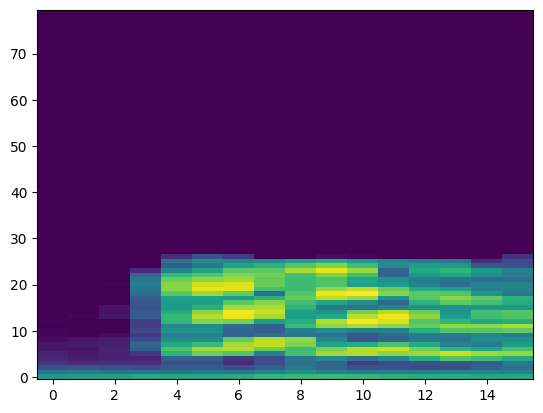

In [11]:
from IPython.display import Audio, display

for d in train_ds:
    mel, audio, orig_audio, len_audio = d
    print(orig_audio.numpy())
    plt.imshow(mel.numpy(), aspect='auto', origin='lower')
    display(Audio(data=orig_audio.numpy(), rate=2000))
    display(Audio(data=audio.numpy(), rate=2000))
    print(mel.max(), mel.min(), audio.shape)
    break

In [9]:
import torch
import torch.nn as nn

class DiversityLoss(nn.Module):
    def __init__(self, epsilon: float = 1e-8):
        """
        Initializes the Diversity Loss module.
        
        Args:
            epsilon: Small value added to the denominator to prevent division by zero.
        """
        super().__init__()
        self.epsilon = epsilon 

    def forward(self, features: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """
        Calculates the feature space diversity loss (L_div) for a batch.

        Args:
            features (torch.Tensor): The generated feature vectors (F(G(Z))). Shape (B, D).
            z (torch.Tensor): The latent input vectors (Z). Shape (B, L).

        Returns:
            torch.Tensor: The mean ratio (L_div), which should be maximized.
        """
        
        # --- 1. Calculate Pairwise Distances ---
        
        # Numerator: Feature Distance Matrix (BxB)
        # ||F(G(z1)) - F(G(z2))||
        feature_dist_matrix = torch.cdist(features, features)
        
        # Denominator: Latent Distance Matrix (BxB)
        # ||z1 - z2||
        latent_dist_matrix = torch.cdist(z, z)

        # --- 2. Compute the Ratio and Exclude Diagonal ---
        
        # Compute the ratio, adding epsilon to stabilize near-zero distances
        ratio_matrix = feature_dist_matrix / (latent_dist_matrix + self.epsilon)

        # The diagonal contains meaningless values (0/epsilon). We must exclude them.
        
        # Create a mask to exclude the diagonal elements (i=j)
        mask = torch.ones_like(ratio_matrix, dtype=torch.bool)
        mask.fill_diagonal_(False)
        
        # Apply the mask and calculate the mean of all non-diagonal ratios
        diversity_loss = ratio_matrix[mask].mean()

        return diversity_loss

# --- Example Usage ---

# 1. Setup
BATCH_SIZE = 32
LATENT_DIM = 10 
FEATURE_DIM = 256

# Instantiate the loss module
l_div = DiversityLoss()

# 2. Simulate Input Data (Tensors must be on the same device)
Z_tensor = torch.randn(BATCH_SIZE, LATENT_DIM) # Input Z
Feature_tensor = torch.randn(BATCH_SIZE, FEATURE_DIM) # Output F(G(Z))

# 3. Calculate Loss
loss_value = l_div(Feature_tensor, Z_tensor)

print(f"Calculated Diversity Loss (L_div): {loss_value.item():.4f}")
print(f"Goal in Optimization: MAXIMIZE this value (e.g., minimize -L_div).")

Calculated Diversity Loss (L_div): 5.9441
Goal in Optimization: MAXIMIZE this value (e.g., minimize -L_div).


In [ ]:
class SincNetCompound(nn.Module):
    def __init__(self, cnn, dnn1, dnn2):  
        super(SincNetCompound, self).__init__()
        self.cnn = cnn
        self.dnn1 = dnn1
        self.dnn2 = dnn2
        
    def forward(self, x):
        x = self.cnn(x)
        x = self.dnn1(x)
        x = self.dnn2(x)
        return x
    
    def extract_features(self, x):
        x = self.cnn(x)
        x = self.dnn1(x)
        return x
    
aud_disc = SincNetCompound(CNN_net, DNN1_net, DNN2_net)
aud_disc.cuda()

sr_model = SincNetCompound(CNN_net_sr, DNN1_net_sr, DNN2_net_sr)
sr_model.cuda()

SincNetCompound(
  (cnn): SincNet(
    (conv): ModuleList(
      (0): SincConv_fast()
      (1): Conv1d(100, 80, kernel_size=(5,), stride=(1,))
      (2): Conv1d(80, 80, kernel_size=(5,), stride=(1,))
    )
    (bn): ModuleList(
      (0): BatchNorm1d(100, eps=1250, momentum=0.05, affine=True, track_running_stats=True)
      (1): BatchNorm1d(80, eps=415, momentum=0.05, affine=True, track_running_stats=True)
      (2): BatchNorm1d(80, eps=137, momentum=0.05, affine=True, track_running_stats=True)
    )
    (ln): ModuleList(
      (0-2): 3 x LayerNorm()
    )
    (act): ModuleList(
      (0-2): 3 x LeakyReLU(negative_slope=0.2)
    )
    (drop): ModuleList(
      (0-2): 3 x Dropout(p=0.1, inplace=False)
    )
    (ln0): LayerNorm()
  )
  (dnn1): MLP(
    (wx): ModuleList(
      (0): Linear(in_features=10960, out_features=2048, bias=True)
      (1-2): 2 x Linear(in_features=2048, out_features=2048, bias=True)
    )
    (bn): ModuleList(
      (0-2): 3 x BatchNorm1d(2048, eps=1e-05, moment

In [11]:
aud_disc(torch.randn(2, wlen).cuda())

tensor([[0.],
        [0.]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [12]:
generator = Generator()
generator.apply(weights_init_normal)
generator.cuda()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=128, out_features=320, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Upsample(scale_factor=2.0, mode='nearest')
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Upsample(scale_factor=2.0, mode='nearest')
    (12): Conv2d(128, 64, 

In [13]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Conv1d, ConvTranspose1d, AvgPool1d, Conv2d
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm

LRELU_SLOPE = 0.1

def init_weights(m, mean=0.0, std=0.01):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean, std)


def apply_weight_norm(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        weight_norm(m)


def get_padding(kernel_size, dilation=1):
    return int((kernel_size*dilation - dilation)/2)

class ResBlock1(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3, 5)):
        super(ResBlock1, self).__init__()
        self.h = h
        self.convs1 = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[2],
                               padding=get_padding(kernel_size, dilation[2])))
        ])
        self.convs1.apply(init_weights)

        self.convs2 = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1)))
        ])
        self.convs2.apply(init_weights)

    def forward(self, x):
        for c1, c2 in zip(self.convs1, self.convs2):
            xt = F.leaky_relu(x, LRELU_SLOPE)
            xt = c1(xt)
            xt = F.leaky_relu(xt, LRELU_SLOPE)
            xt = c2(xt)
            x = xt + x
        return x

    def remove_weight_norm(self):
        for l in self.convs1:
            remove_weight_norm(l)
        for l in self.convs2:
            remove_weight_norm(l)


class ResBlock2(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3)):
        super(ResBlock2, self).__init__()
        self.h = h
        self.convs = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1])))
        ])
        self.convs.apply(init_weights)

    def forward(self, x):
        for c in self.convs:
            xt = F.leaky_relu(x, LRELU_SLOPE)
            xt = c(xt)
            x = xt + x
        return x

    def remove_weight_norm(self):
        for l in self.convs:
            remove_weight_norm(l)


class HIFIGenerator(torch.nn.Module):
    def __init__(self, h):
        super(HIFIGenerator, self).__init__()
        self.h = h
        self.num_kernels = len(h.resblock_kernel_sizes)
        self.num_upsamples = len(h.upsample_rates)
        self.conv_pre = weight_norm(Conv1d(80, h.upsample_initial_channel, 7, 1, padding=3))
        resblock = ResBlock1 if h.resblock == '1' else ResBlock2

        self.ups = nn.ModuleList()
        for i, (u, k) in enumerate(zip(h.upsample_rates, h.upsample_kernel_sizes)):
            self.ups.append(weight_norm(
                ConvTranspose1d(h.upsample_initial_channel//(2**i), h.upsample_initial_channel//(2**(i+1)),
                                k, u, padding=(k-u)//2)))

        self.resblocks = nn.ModuleList()
        for i in range(len(self.ups)):
            ch = h.upsample_initial_channel//(2**(i+1))
            for j, (k, d) in enumerate(zip(h.resblock_kernel_sizes, h.resblock_dilation_sizes)):
                self.resblocks.append(resblock(h, ch, k, d))

        self.conv_post = weight_norm(Conv1d(ch, 1, 7, 1, padding=3))
        self.ups.apply(init_weights)
        self.conv_post.apply(init_weights)

    def forward(self, x):
        x = self.conv_pre(x)
        for i in range(self.num_upsamples):
            x = F.leaky_relu(x, LRELU_SLOPE)
            x = self.ups[i](x)
            xs = None
            for j in range(self.num_kernels):
                if xs is None:
                    xs = self.resblocks[i*self.num_kernels+j](x)
                else:
                    xs += self.resblocks[i*self.num_kernels+j](x)
            x = xs / self.num_kernels
        x = F.leaky_relu(x)
        x = self.conv_post(x)
        x = torch.tanh(x)

        return x
    
    
hifigan_config = {
    "resblock": "1",
    "num_gpus": 0,
    "batch_size": 16,
    "learning_rate": 0.0002,
    "adam_b1": 0.8,
    "adam_b2": 0.99,
    "lr_decay": 0.999,
    "seed": 1234,

    "upsample_rates": [8,8,2,2],
    "upsample_kernel_sizes": [16,16,4,4],
    "upsample_initial_channel": 512,
    "resblock_kernel_sizes": [3,7,11],
    "resblock_dilation_sizes": [[1,3,5], [1,3,5], [1,3,5]],

    "segment_size": 8192,
    "num_mels": 80,
    "num_freq": 1025,
    "n_fft": 1024,
    "hop_size": 256,
    "win_size": 1024,

    "sampling_rate": 22050,

    "fmin": 0,
    "fmax": 8000,
    "fmax_for_loss": None,
    "num_workers": 4,

    "dist_config": {
        "dist_backend": "nccl",
        "dist_url": "tcp://localhost:54321",
        "world_size": 1
    }
}

hifigan_config = dycomutils.config.ConfigDict(hifigan_config)
    
 

In [14]:
hifigan_weight = torch.load('/home/desild/work/academic/sem3/TrustworthyML-assignment/tacotron2/vctk/models/pretrain_hifigan/generator_v1')
hifigan = HIFIGenerator(hifigan_config)
hifigan.load_state_dict(hifigan_weight['generator'])
hifigan.cuda()

/home/desild/work/academic/sem3/TrustworthyML-assignment/.conda/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


HIFIGenerator(
  (conv_pre): Conv1d(80, 512, kernel_size=(7,), stride=(1,), padding=(3,))
  (ups): ModuleList(
    (0): ConvTranspose1d(512, 256, kernel_size=(16,), stride=(8,), padding=(4,))
    (1): ConvTranspose1d(256, 128, kernel_size=(16,), stride=(8,), padding=(4,))
    (2): ConvTranspose1d(128, 64, kernel_size=(4,), stride=(2,), padding=(1,))
    (3): ConvTranspose1d(64, 32, kernel_size=(4,), stride=(2,), padding=(1,))
  )
  (resblocks): ModuleList(
    (0): ResBlock1(
      (convs1): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(3,), dilation=(3,))
        (2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(5,), dilation=(5,))
      )
      (convs2): ModuleList(
        (0-2): 3 x Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=(1,))
      )
    )
    (1): ResBlock1(
      (convs1): ModuleList(
        (0): Conv1d(256, 256, kernel_size=(7,), stride=(1

In [15]:
img_disc = ImgDiscriminator()
img_disc.cuda()
img_disc(torch.randn(2,1,80,16).cuda())

tensor([[ 0.0802],
        [-0.0714]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [16]:
mel = generator(torch.randn(1, opt.latent_dim).cuda())
print(mel.shape)
audios = hifigan(mel)

torch.Size([1, 80, 16])


In [17]:
audios.shape

torch.Size([1, 1, 4096])

In [18]:
from itertools import chain

optimizer_dis_aud = torch.optim.AdamW(aud_disc.parameters(), lr=float(lr), eps=1e-8, weight_decay=1e-4) 
optimizer_dis_img = torch.optim.AdamW(img_disc.parameters(), lr=float(lr), eps=1e-8, weight_decay=1e-4) 
optimizer_gen = torch.optim.AdamW(chain(generator.parameters(), hifigan.parameters()), lr=float(lr), eps=1e-8, weight_decay=1e-4) 

In [19]:
from IPython.display import Audio, display
from tqdm import tqdm

with tqdm(total=config.epochs, desc="Processing Batches") as pbar:
    for epoch in range(config.epochs):
    # Used to calculate avg items/sec over epoch
        epoch_logs = []
        for i, batch in enumerate(train_loader):
            #(mel, aud), y, _, _, sp_id, _ = batch_to_gpu(batch)
            true_mel, true_aud, orig_audio, _ = batch
            true_mel = to_gpu(true_mel).float()
            true_aud = to_gpu(true_aud).float()

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_gen.zero_grad()
            # Sample noise as generator input
            z = Variable(torch.randn(1, opt.latent_dim).cuda())
            
            mel = generator(torch.randn(true_aud.size(0), opt.latent_dim).cuda())
            audios = hifigan(mel)
            audios = audios[:,:, audios.shape[-1]//2 - true_aud.shape[-1]//2 : audios.shape[-1]//2 + true_aud.shape[-1]//2]
            feat = sr_model.extract_features(audios.squeeze(1))
            
            #print(audios.shape, true_aud.shape)
            # Calculate generator loss
            img_validity = img_disc(mel.unsqueeze(1))
            audio_validity = aud_disc(audios.squeeze(1))
            g_loss = -torch.mean(audio_validity) + -torch.mean(img_validity) - l_div(feat, z)

            g_loss.backward()
            optimizer_gen.step()

            # ---------------------
            #  Train Audio Discriminator
            # ---------------------

            optimizer_dis_aud.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            d_real = aud_disc(true_aud)
            d_fake = aud_disc(audios.squeeze(1).detach())

            gradient_penalty = compute_gradient_penalty(aud_disc, true_aud.data, audios.squeeze(1).data)
            
            # Adversarial loss
            d_loss_aud = -torch.mean(d_real) + torch.mean(d_fake) + opt.lambda_gp * gradient_penalty

            d_loss_aud.backward()
            optimizer_dis_aud.step()
            
            # ---------------------
            #  Train Image Discriminator
            # ---------------------

            optimizer_dis_img.zero_grad()

            # Measure discriminator's ability to classify real from generated samples
            d_real = img_disc(true_mel.unsqueeze(1))
            d_fake = img_disc(mel.unsqueeze(1).detach())

            #print(true_mel.data.shape, mel.data.shape)
            gradient_penalty = compute_gradient_penalty(img_disc, true_mel.data, mel.data)
            
            # Adversarial loss
            d_loss_img = -torch.mean(d_real) + torch.mean(d_fake) + opt.lambda_gp * gradient_penalty

            d_loss_img.backward()
            optimizer_dis_img.step()
            
            epoch_logs.append({
            "d_mel_loss": d_loss_img.item(),
            "d_aud_loss": d_loss_aud.item(),
            "g_loss": g_loss.item(),
            })
            
            batches_done = epoch * len(train_ds) + i
            if batches_done % opt.sample_interval == 0:
                os.makedirs("images/HIFIGAN_ADV/", exist_ok=True)
                save_image(mel.unsqueeze(1)[:25], "images/HIFIGAN_ADV/%d.png" % batches_done, nrow=5, normalize=True)
            
            # print(
            #     "[Epoch %d/%d] [Batch %d/%d] [loss: %f] [error: %f]"
            #     % (epoch, config.epochs, i, len(train_loader), loss.item(), err.item())
            # )
            
        
        epoch_df = pd.DataFrame(epoch_logs)
        run["train/epoch/d_mel_loss"].append(epoch_df["d_mel_loss"].mean())
        run["train/epoch/d_aud_loss"].append(epoch_df["d_aud_loss"].mean())
        run["train/epoch/g_loss"].append(epoch_df["g_loss"].mean())

        pbar.update(1)


# %%
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

model_type = "HIFIGAN_ADV"
os.makedirs("models/{}/{}".format(model_type, timestamp), exist_ok=True)

config_dict = {
    "config": config.__dict__,
    "model_config": {
        "CNN_arch": CNN_arch,
        "DNN1_arch": DNN1_arch,
        "DNN2_arch": DNN2_arch,
        "fs": fs,
        "n_mel_channels": config.n_mel_channels
    }
}

save_dict = {
    'dis_aud': aud_disc.state_dict(),
    'dis_img': img_disc.state_dict(),
    'gen': generator.state_dict(),
    'hifigan': hifigan.state_dict(),
    'optimizer_dis_aud': optimizer_dis_aud.state_dict(),
    'optimizer_dis_img': optimizer_dis_img.state_dict(),
    'optimizer_gen': optimizer_gen.state_dict(),
    'epoch': config.epochs,
    'batch_size': config.batch_size,
    'learning_rate': float(lr),
    'config': config_dict
    }


torch.save(save_dict, "models/{}/{}/checkpoint.pth".format(model_type, timestamp))
# torch.save(model_waveglow.state_dict(), "models/SINCNET/{}/waveglow.pth".format(timestamp))
# torch.save(audio_discriminator.state_dict(), "models/SINCNET/{}/audio_discriminator.pth".format(timestamp))

run["model/saved_model/checkpoint"].upload("models/{}/{}/checkpoint.pth".format(model_type, timestamp))
# run["model/saved_model/waveglow"].upload("models/SINCNET/{}/waveglow.pth".format(timestamp))
# run["model/saved_model/audio_dis"].upload("models/SINCNET/{}/audio_discriminator.pth".format(timestamp))



Processing Batches:   0%|          | 1/500 [06:57<57:51:53, 417.46s/it]


KeyboardInterrupt: 